>
> # MaaSSim tutorial

 ### quickstart

In [2]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

prepare

In [3]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
import logging

In [4]:
import pandas as pd

In [5]:
import ExMAS

In [6]:
params = get_config('../../data/config/delft.json')  # load configuration

In [7]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 4 # 1 hour of simulation
params.nP = 500 # reuqests (and passengers)
params.nV = 100 # vehicles

In [8]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

In [9]:
inData = load_G(inData, params)  # load network graph 

In [10]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [11]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

14-10-20 11:50:10-INFO-Initializing pairwise trip shareability between 500 and 500 trips.
14-10-20 11:50:10-INFO-creating combinations
14-10-20 11:50:10-INFO-249500	 nR*(nR-1)
14-10-20 11:50:15-INFO-Reduction of feasible pairs by 99.70%
14-10-20 11:50:15-INFO-Degree 2 	Completed
14-10-20 11:50:15-INFO-trips to extend at degree 2 : 1828
14-10-20 11:50:17-INFO-At degree 2 feasible extensions found out of 448 searched
14-10-20 11:50:17-INFO-Degree 3 	Completed
14-10-20 11:50:17-INFO-trips to extend at degree 3 : 448
14-10-20 11:50:18-INFO-At degree 3 feasible extensions found out of 45 searched
14-10-20 11:50:18-INFO-Degree 4 	Completed
14-10-20 11:50:18-INFO-Max degree reached 4
14-10-20 11:50:18-INFO-Trips still possible to extend at degree 4 : 45


simulate

In [12]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

14-10-20 11:50:20-INFO-Matching 500 trips to 2821 rides in order to minimize u_pax
14-10-20 11:50:21-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,356 
reduced by matching to:                2,092
14-10-20 11:50:22-WARNING-Setting up 4h simulation at 2020-10-14 09:50:36 for 100 vehicles and 500 passengers in Delft, Netherlands
14-10-20 11:50:37-WARNING-simulation time 13.4 s
14-10-20 11:50:37-WARNING-assertion tests for simulation results - passed


<AxesSubplot:>

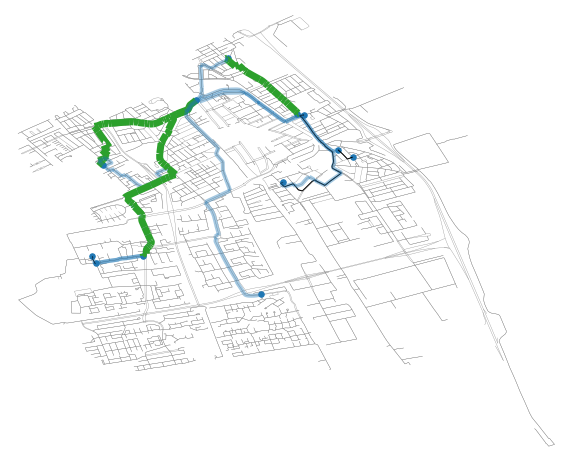

In [48]:
df = sim.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==19], lw = 1)

In [27]:
params.shareability.share = 0
sim2 = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

14-10-20 11:57:39-WARNING-Setting up 4h simulation at 2020-10-14 09:50:36 for 100 vehicles and 500 passengers in Delft, Netherlands
14-10-20 11:57:57-WARNING-simulation time 17.5 s
14-10-20 11:57:58-WARNING-assertion tests for simulation results - passed


<AxesSubplot:>

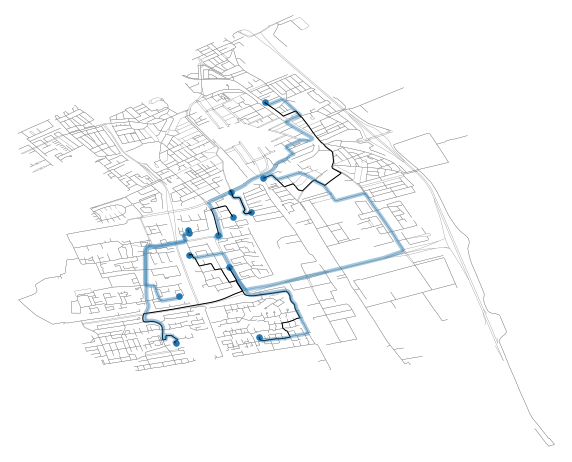

In [47]:
df = sim2.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()==1:
        break
plot_veh(inData.G, df[df.veh ==8], lw = 1)

-----